In [5]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.rc("figure", figsize=(8, 8))

In [6]:
network = pypsa.examples.ac_dc_meshed(from_master=True)

INFO:pypsa.io:Imported network ac-dc-meshed.nc has buses, carriers, generators, global_constraints, lines, links, loads


In [7]:
# get current type (AC or DC) of the lines from the buses
lines_current_type = network.lines.bus0.map(network.buses.carrier)
lines_current_type

Line
0    AC
1    AC
2    DC
3    DC
4    DC
5    AC
6    AC
Name: bus0, dtype: object

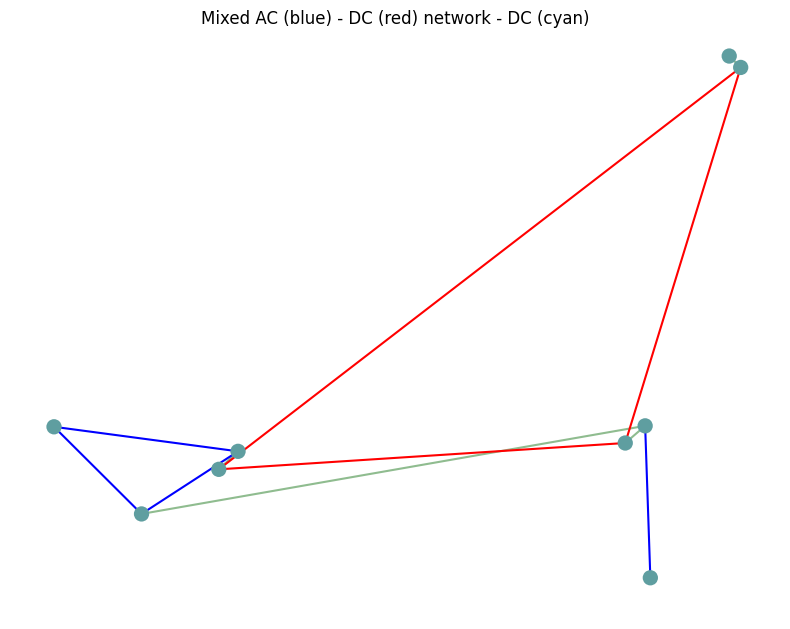

In [8]:
network.plot(
    line_colors=lines_current_type.map(lambda ct: "r" if ct == "DC" else "b"),
    title="Mixed AC (blue) - DC (red) network - DC (cyan)",
    color_geomap=True,
    jitter=0.3,
    geomap=True
)
plt.tight_layout()

In [9]:
network.links.loc["Norwich Converter", "p_nom_extendable"] = False


In [10]:
network.determine_network_topology()
network.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in network.sub_networks.obj
]
network.sub_networks["n_buses"] = [len(sn.buses()) for sn in network.sub_networks.obj]

network.sub_networks

attribute,carrier,slack_bus,obj,n_branches,n_buses
SubNetwork,,,,,
0,AC,Manchester,SubNetwork 0,3,3
1,DC,Norwich DC,SubNetwork 1,3,3
2,AC,Frankfurt,SubNetwork 2,1,2
3,AC,Norway,SubNetwork 3,0,1


In [11]:
network.snapshots


DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)

In [12]:
network.generators


,bus,capital_cost,efficiency,marginal_cost,p_nom,p_nom_extendable,p_nom_min,carrier,control,type,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Manchester Wind,Manchester,2793.651603,1.000000,0.110000,80.0,True,100.0,wind,Slack,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Manchester Gas,Manchester,196.615168,0.350026,4.532368,50000.0,True,0.0,gas,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Norway Wind,Norway,2184.374796,1.000000,0.090000,100.0,True,100.0,wind,Slack,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Norway Gas,Norway,158.251250,0.356836,5.892845,20000.0,True,0.0,gas,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Frankfurt Wind,Frankfurt,2129.456122,1.000000,0.100000,110.0,True,100.0,wind,Slack,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Frankfurt Gas,Frankfurt,102.676953,0.351666,4.086322,80000.0,True,0.0,gas,PQ,,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


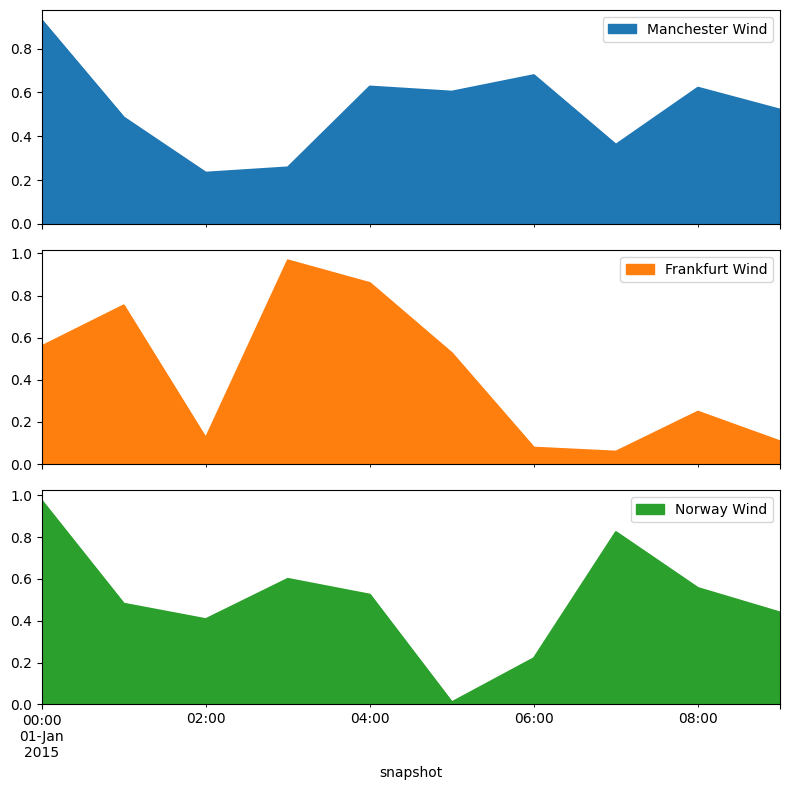

In [13]:
network.generators_t.p_max_pu.plot.area(subplots=True)
plt.tight_layout()

In [14]:
network.optimize()

Index(['2', '3', '4'], dtype='object', name='Line')


Index(['0', '1', '5', '6'], dtype='object', name='Line')
Index(['2', '3', '4'], dtype='object', name='Line')
Index(['0', '1', '5', '6'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.08s
INFO:linopy.solvers:GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-pak8przt.lp --output /tmp/linopy-solve-x_qczpmy.sol
Reading problem data from '/tmp/linopy-problem-pak8przt.lp'...
467 rows, 187 columns, 986 non-zeros
2650 lines were read
GLPK Simplex Optimizer, v4.65
467 rows, 187 columns, 986 non-zeros
Preprocessing...
371 rows, 186 columns, 890 non-zeros
Scaling...
 A: min|aij| =  9.693e-03  max|aij| =  1.215e+00  ratio =  1.254e+02
GM: min|aij| =  5.786e-01  max|aij| =  1.728e+00  ratio =  2.987e+00
EQ: min|aij| =  3.378e-01  max|aij| =  1.000e+00  ratio =  2.961e+00
Constructing initial basis...
Size of triangular part is 371
      0: obj =  -2.104300118e+07 inf =   9.187e+04

('ok', 'optimal')

In [15]:
network.objective


-3474094.131

In [16]:
network.objective + network.objective_constant


18440973.38727914

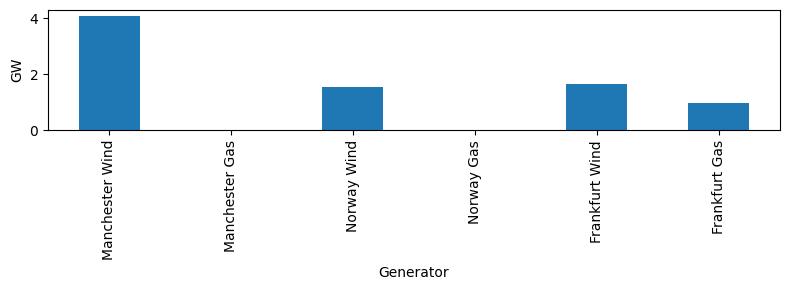

In [17]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()

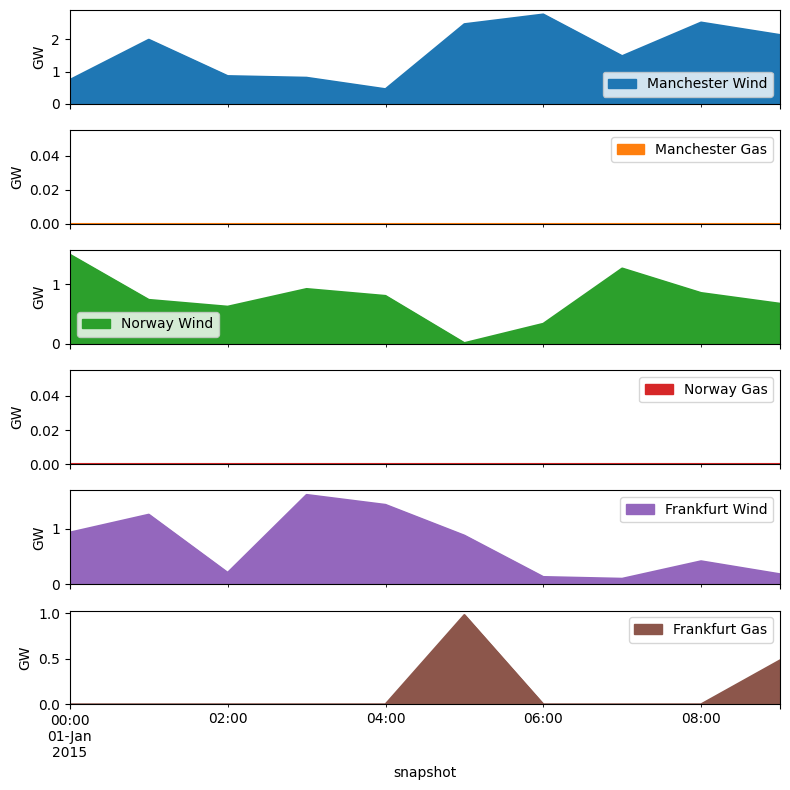

In [18]:
network.generators_t.p.div(1e3).plot.area(subplots=True, ylabel="GW")
plt.tight_layout()

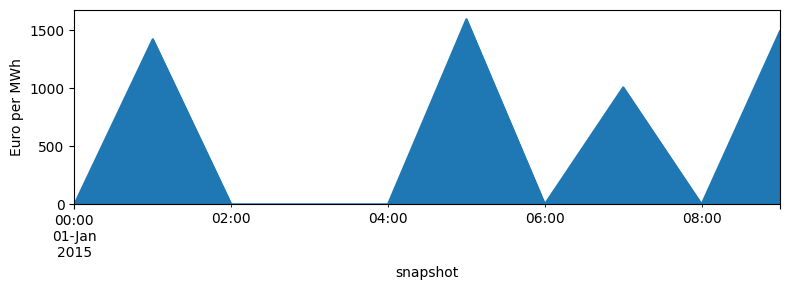

In [19]:
network.buses_t.marginal_price.mean(1).plot.area(figsize=(8, 3), ylabel="Euro per MWh")
plt.tight_layout()

In [20]:
network.links_t.p0

Link,Norwich Converter,Norway Converter,Bremen Converter,DC link
snapshot,,,,
2015-01-01 00:00:00,-250.8410,674.5850,-423.7440,-317.9980
2015-01-01 01:00:00,93.6719,-116.7270,23.0553,-96.6013
2015-01-01 02:00:00,-285.2340,581.9710,-296.7360,317.9980
2015-01-01 03:00:00,-85.7721,272.5580,-186.7860,-317.9980
2015-01-01 04:00:00,317.3670,-79.7495,-237.6170,-317.9980
2015-01-01 05:00:00,386.7480,-494.1980,107.4500,-317.9980
2015-01-01 06:00:00,900.0000,-257.5210,-642.4790,317.9980
2015-01-01 07:00:00,123.6770,971.9190,-1095.6000,-86.8587
2015-01-01 08:00:00,244.7160,850.8800,-1095.6000,317.9980


In [21]:
network.lines_t.p0

Line,0,1,2,3,4,5,6
snapshot,,,,,,,
2015-01-01 00:00:00,79.4749,-38.1056,-52.9672,-303.8080,370.7760,-202.7270,-534.341
2015-01-01 01:00:00,-486.5070,749.9940,-31.6237,62.0483,-54.6789,393.7160,-823.211
2015-01-01 02:00:00,-287.6780,414.1490,10.1569,-275.0770,306.8930,280.9070,173.898
2015-01-01 03:00:00,-45.4725,234.4700,-34.0407,-119.8130,152.7450,-232.7170,-743.788
2015-01-01 04:00:00,-73.2078,295.4210,-227.1980,90.1683,10.4188,-240.1060,-883.818
2015-01-01 05:00:00,-594.5000,1198.0800,-125.9040,260.8440,-233.3540,19.3590,-1030.850
2015-01-01 06:00:00,-661.2950,1378.4200,-632.3710,267.6290,10.1079,-53.4484,319.387
2015-01-01 07:00:00,-383.7690,540.9070,-469.9260,-346.2480,625.6700,393.7160,600.729
2015-01-01 08:00:00,-778.2810,1444.0700,-522.1160,-277.4000,573.4800,229.2940,501.346


In [22]:
network.buses_t.p

Bus,London,Norwich,Norwich DC,Manchester,Bremen,Bremen DC,Frankfurt,Norway,Norway DC
snapshot,,,,,,,,,
2015-01-01 00:00:00,282.201756,-164.621564,-250.8410,-117.580440,-534.340378,-423.7440,534.341153,-0.000836,674.5850
2015-01-01 01:00:00,-880.223261,-356.278046,93.6719,1236.500376,-823.210934,23.0553,823.213894,-0.000047,-116.7270
2015-01-01 02:00:00,-568.585312,-133.242353,-285.2340,701.827124,173.897870,-296.7360,-173.897928,-0.000744,581.9710
2015-01-01 03:00:00,187.244855,-467.187439,-85.7721,279.942178,-743.788306,-186.7860,743.788236,-0.000233,272.5580
2015-01-01 04:00:00,166.897831,-535.526858,317.3670,368.629241,-883.817781,-237.6170,883.819245,-0.000373,-79.7495
2015-01-01 05:00:00,-613.859052,-1178.724266,386.7480,1792.586681,-1030.848687,107.4500,1030.848757,0.000251,-494.1980
2015-01-01 06:00:00,-607.846287,-1431.870681,900.0000,2039.712900,319.386410,-642.4790,-319.386752,0.000035,-257.5210
2015-01-01 07:00:00,-777.484622,-147.190467,123.6770,924.675111,600.732759,-1095.6000,-600.728866,-0.001450,971.9190
2015-01-01 08:00:00,-1007.575264,-1214.775068,244.7160,2222.351918,501.350224,-1095.6000,-501.346780,0.000507,850.8800
